In [1]:
import rasterio
import numpy as np
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
from collections import namedtuple
import seaborn as sns
import matplotlib

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import csv

import fiona
import time
from shapely.geometry import mapping, shape
from shapely.geometry import box as shBox
from rasterio import windows as win
from statsmodels.formula.api import ols
import rasterio.plot

# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn import preprocessing
# from sklearn import linear_model
# from sklearn import metrics


import io
from scipy import misc
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [2]:
lc_Address=r'Rasters\EU_LC_100.img'
tc_Address=r'Rasters\tc.img'
st_address=r'Rasters\st.img'
at_address=r'Rasters\airTemp.img'
eaa_raster_address=r'Rasters\EAA.img'
bldgSum_address = r'Rasters\bldgSum.tif'
eaa_vector_address=r'Vectors\RomeUrbanArea.shp'
dem_address= r'Rasters\dem.img'
pet_address= r'Rasters\PET.tif'
alb_address= r'Rasters\albedo.nc'

In [3]:
def findWindow (shapeBound,mainRasterBnd,mainRasterCellSize):
    startRow = int((mainRasterBnd[3] - shapeBound[3])/mainRasterCellSize)
    endRow   = int((shapeBound[3] - shapeBound[1])/mainRasterCellSize)+1+startRow
    startCol = int((shapeBound[0] - mainRasterBnd[0])/mainRasterCellSize)
    endCol   = int((shapeBound[2] - shapeBound[0])/mainRasterCellSize)+1+startCol
    return (startRow,endRow,startCol,endCol)

In [4]:
with rasterio.open(tc_Address) as rst_tc:
            kwds = rst_tc.meta.copy()
            mainRasterBnd=rst_tc.bounds
            cellSize= kwds['transform'][0]

In [5]:
# name field from the eaa vector
nameField='URAU_NAME'
idField='EAA_ID'
countryCode='CNTR_CODE'
kbtuField='KBTU'

In [6]:
for pol in fiona.open(eaa_vector_address):
    #for pol in fiona.open(ecoAcAreasShapefile):
    eaa_name=(pol['properties'][nameField])
    eaa_country=(pol['properties'])[countryCode]
    eaa_id=(pol['properties'][idField])
    # kbtu per sq feet for residential use per year
    kbtu=(pol['properties'][kbtuField])
#     poly_Ycoor=(pol['properties']['Y_coor'])
    poly=(shape(pol['geometry']))
    #msaPoly=[shape(pol['geometry']) for pol in fiona.open(masShapeAddress)]

    with rasterio.open(tc_Address) as rst_tc:
        kwds = rst_tc.meta.copy()
        mainRasterBnd=rst_tc.bounds
        cellSize= kwds['transform'][0]

    polyBound = poly.bounds

    # create a window parameter tuple.   
    winProcessing=findWindow(polyBound,mainRasterBnd,cellSize)
    #(row_start, row_stop), (col_start, col_stop)
    window_use=((winProcessing[0],winProcessing[1]),(winProcessing[2],winProcessing[3]))

    # set the cells that do not have the city id as np.nan. This way we are getting cells insdie the boundary only.
    with rasterio.open(eaa_raster_address) as src:
        eaaAr=src.read(1, window=window_use)
        eaaNoData = (src.meta.copy())['nodata']
        arrayShapes=eaaAr.shape
        eaaAr=eaaAr.flatten()    
        
    with rasterio.open(pet_address) as src:
        pet=src.read(1, window=window_use)
        petNoData = (src.meta.copy())['nodata']
        pet=pet.astype('float')
        pet=pet.flatten()
        
    with rasterio.open(tc_Address) as rst_tc:
        tc_ar=rst_tc.read(1, window=window_use)
        tcNoData = (rst_tc.meta.copy())['nodata']
        tc_ar=tc_ar.astype('float')
        #nlcd_tc_win_ar[eaaAr!=eaa_id]=np.nan
        tc_ar=tc_ar.flatten()
        kwds = rst_tc.meta.copy()
        #print ('got the nlcd-tc layer')

    with rasterio.open(lc_Address) as src:
        lc_ar=src.read(1, window=window_use)
        lcNoData = (src.meta.copy())['nodata']
        lc_ar=lc_ar.astype('float')
        #nlcd_lc[eaaAr!=eaa_id]=np.nan
        lc_ar=lc_ar.flatten()
        #print('got the nlcd-lc layer')

    with rasterio.open(st_address) as src:
        st=src.read(1, window=window_use)
        stNoData = (src.meta.copy())['nodata']
        st=st.astype('float')
        st=st.flatten()
        
    with rasterio.open(at_address) as src:
        at=src.read(1, window=window_use)
        atNoData = (src.meta.copy())['nodata']
        at=at.astype('float')
        at=at.flatten()
        
    with rasterio.open(dem_address) as src:
        dem=src.read(1, window=window_use)
        demNoData = (src.meta.copy())['nodata']
        dem=dem.astype('float')
        dem=dem.flatten()
    
    with rasterio.open(bldgSum_address) as src:
        bldgSum = src.read(1,window=window_use)
        bldgNodata = (src.meta.copy())['nodata']
        bldgSum = bldgSum.astype('float')
        bldgSum = bldgSum.flatten()
        
    allArrays=np.dstack((tc_ar,lc_ar,st,at,eaaAr,bldgSum,dem,pet))
    allArrays=allArrays[0,:,:]

    df=pd.DataFrame(allArrays,columns=['tc','lc','st','at','eaaAr','bldgSum','elevation','pet'])

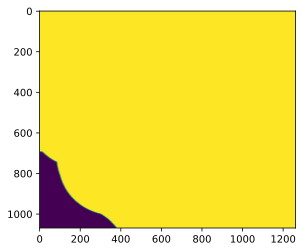

In [7]:
 with rasterio.open(dem_address) as src:
        dem = src.read(1,window=window_use)
        plt.imshow(dem)

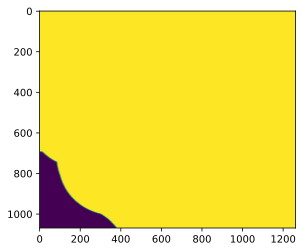

In [8]:
ar_test = np.array(df.elevation)
plt.imshow(ar_test.reshape(kwds['height'],kwds['width']))

In [94]:
df.head()

,tc,lc,st,at,eaaAr,bldgSum,elevation,pet
0,63.0,311.0,3726.0,2986.0,0.0,0.0,175.0,203.0
1,74.0,311.0,3741.0,2986.0,0.0,0.0,180.0,203.0
2,74.0,311.0,3741.0,2986.0,0.0,0.0,181.0,203.0
3,74.0,311.0,3754.0,2985.0,0.0,0.0,180.0,203.0
4,69.0,311.0,3796.0,2985.0,0.0,0.0,180.0,203.0


In [95]:
st=df['st'].replace(stNoData, np.NaN)
at=df['at'].replace(atNoData, np.NaN)
lc=df['lc'].replace(lcNoData, np.NaN)
tc=df['tc'].replace(tcNoData, np.NaN)
eaaAr=df['eaaAr'].replace(eaaNoData, np.NaN)
bldgSum=df['bldgSum'].replace(bldgNodata, np.NaN)
elevation=df['elevation'].replace(demNoData, np.NaN)
pet=df['pet'].replace(petNoData,np.NaN)
pet=pet.replace(0,np.NaN)
st=st.replace(0,np.nan)
at=at.replace(0,np.nan)

In [96]:
list_of_series=[st,at,lc,tc,eaaAr,bldgSum,elevation,pet]
df = pd.DataFrame(list_of_series)
df=df.transpose()
df.head()

,st,at,lc,tc,eaaAr,bldgSum,elevation,pet
0,3726.0,2986.0,311.0,63.0,NaN,0.0,175.0,203.0
1,3741.0,2986.0,311.0,74.0,NaN,0.0,180.0,203.0
2,3741.0,2986.0,311.0,74.0,NaN,0.0,181.0,203.0
3,3754.0,2985.0,311.0,74.0,NaN,0.0,180.0,203.0
4,3796.0,2985.0,311.0,69.0,NaN,0.0,180.0,203.0


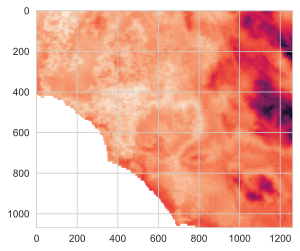

In [85]:
ar_test = np.array(df.pet)
plt.imshow(ar_test.reshape(kwds['height'],kwds['width']))

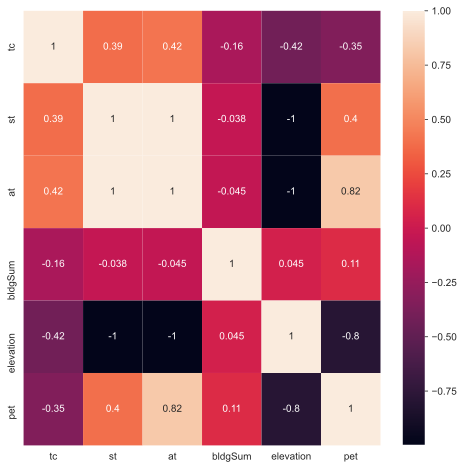

In [86]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
sns.heatmap(((df[['tc','st','at','bldgSum','elevation','pet']]).corr()), annot=True)

In [97]:
df['st']=df['st']/100;
df['at']=df['at']/100;
df['bldgSum']=df['bldgSum']/100;
df['pet']=df['pet']/100

In [98]:
#check this difference
df.pet.mean(skipna=True)

1.982199981181366

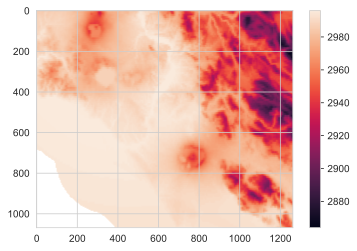

In [99]:
ar_test = np.array(at)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

## This is a simple regression

In [100]:
features_airModel = ['tc','st','bldgSum','elevation','pet']
depVar_airModel = df['at']
indepVar_airModel = sm.add_constant(df[features_airModel],has_constant='add')
# Fit and summarize OLS model
airModel = sm.OLS(depVar_airModel, indepVar_airModel,missing='drop')
results_airModel = airModel.fit()
print(results_airModel.summary())
## for prediction the following code will be used:
predict_airModel = results_airModel.get_prediction(indepVar_airModel)
predict_airModel = predict_airModel.summary_frame(alpha=0.05)

                            OLS Regression Results                            
Dep. Variable:                     at   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 1.672e+07
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        17:57:09   Log-Likelihood:             2.2539e+06
No. Observations:             1047752   AIC:                        -4.508e+06
Df Residuals:                 1047746   BIC:                        -4.508e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.5119      0.001   2.45e+04      0.0

## tc + e1 ---> st + e2 ----> at + f(e1,e2)

In [101]:
#could it be a good idea to add more independent variables? i.e. imperviousness, soil, vegetation typologies, and when extending to whole eu, ecoregions, latitude etc.
#I tried to add also bldgSum, (it improved a little the r-squared) but the following block returns a traceback error

df['tc0']=0
features_st_model = ['tc','pet']
depVar_st_model = df['st']
indepVar_st_model = sm.add_constant(df[features_st_model],has_constant='add')
st_model = sm.OLS(depVar_st_model, indepVar_st_model,missing='drop')
results_st_model = st_model.fit()
print(results_st_model.summary())
# now lets record the estimated ST
predict_st = results_st_model.get_prediction(indepVar_st_model)
predict_st = predict_st.summary_frame(alpha=0.05)
df['estimated_st'] = predict_st['mean']
df['err_st']=((predict_st['obs_ci_upper']-predict_st['obs_ci_lower'])/2)

df.head()


                            OLS Regression Results                            
Dep. Variable:                     st   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                 9.402e+05
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        17:57:12   Log-Likelihood:            -2.5881e+06
No. Observations:             1047752   AIC:                         5.176e+06
Df Residuals:                 1047749   BIC:                         5.176e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6914      0.075     62.722      0.0

,st,at,lc,tc,eaaAr,bldgSum,elevation,pet,tc0,estimated_st,err_st
0,37.26,29.86,311.0,63.0,NaN,0.0,175.0,2.03,0,38.751989,5.607516
1,37.41,29.86,311.0,74.0,NaN,0.0,180.0,2.03,0,37.892321,5.607518
2,37.41,29.86,311.0,74.0,NaN,0.0,181.0,2.03,0,37.892321,5.607518
3,37.54,29.85,311.0,74.0,NaN,0.0,180.0,2.03,0,37.892321,5.607518
4,37.96,29.85,311.0,69.0,NaN,0.0,180.0,2.03,0,38.283079,5.607517


In [102]:
#checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = results_st_model.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

[716.1178673416059, 1.1429253724984374, 1.142925372498447]

In [71]:
np.array(vif).mean()

239.4679060288486

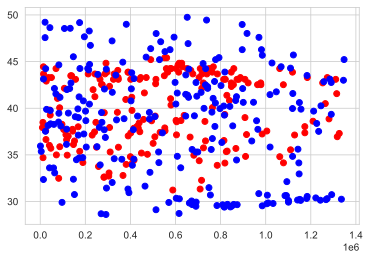

45.59593952511331

In [103]:
# now let's see what whould be ST wit TC0
features_st_model_tc0 = ['tc0','pet']
indepVar_st_model_tc0 = sm.add_constant(df[features_st_model_tc0],has_constant='add')
predict_st_tc0 = results_st_model.get_prediction(indepVar_st_model_tc0)
predict_st_tc0 = predict_st_tc0.summary_frame(alpha=0.05)

# create a col that shows the estiamted st when tc is 0
df['estimated_st_tc0'] = predict_st_tc0['mean']
df.head()

#print(predict_st_tc0)

plt.plot(df['estimated_st'].sample(250),marker='o',color='red',linestyle='None')
plt.plot(df['st'].sample(250),marker='o',color='blue',linestyle='None')
plt.show()

df.estimated_st.max()

In [118]:
# now let's build a model that uses st as the independent variable and estimates air temperature
features_at_model = ['st']
depVar_air_model = df['at']
indepVar_air_model = sm.add_constant(df[features_at_model],has_constant='add')
at_model = sm.OLS(depVar_air_model,indepVar_air_model,missing='drop')
results_at_model = at_model.fit()
print(results_at_model.summary())
# now let's estiamte air temperature with this model
predict_at = results_at_model.get_prediction(indepVar_air_model)
predict_at = predict_at.summary_frame(alpha=0.05)
df['estimated_air'] = predict_at['mean']
df['err_at']=((predict_at['obs_ci_upper']-predict_at['obs_ci_lower'])/2)
# now let's estiamte air temperature from esitmated_st_tc0
features_at_model_tc0 = ['estimated_st_tc0']
indepVar_air_model_tc0 = sm.add_constant(df[features_at_model_tc0],has_constant='add')

predict_air_tc0 = results_st_model.get_prediction(indepVar_air_model_tc0)
predict_air_tc0 = predict_air_tc0.summary_frame(alpha=0.05)
# create a col that shows the estiamted st when tc is 0
df['estimated_at_tc0'] = predict_air_tc0['mean']

# now let's calculate cooling
df['cooling'] = df['estimated_at_tc0']-df['estimated_air']
df.head()

                            OLS Regression Results                            
Dep. Variable:                     at   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                 7.018e+04
Date:                Fri, 22 May 2020   Prob (F-statistic):               0.00
Time:                        19:24:58   Log-Likelihood:                 353.27
No. Observations:             1250312   AIC:                            -702.5
Df Residuals:                 1250310   BIC:                            -678.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.3523      0.001   1.99e+04      0.0

ValueError: shapes (1349078,2) and (3,) not aligned: 2 (dim 1) != 3 (dim 0)

In [36]:
df['propagated_error']=np.sqrt((np.square(df['err_st']/df['estimated_st']))*2 + (np.square(df['err_at']/df['estimated_air']))*2)
#error of air temperature estimated

In [166]:
df.head()

,st,at,lc,tc,eaaAr,bldgSum,elevation,tc0,estimated_st,estimated_st_tc0,...,estimated_at_tc0,cooling,coolingst,uncert_est_st,deviation_est_st,deviation_est_at,prova,err_st,err_at,propagated_error
0,37.26,29.86,311.0,63.0,NaN,0.0,175.0,0,37.494680,43.295053,...,39.308903,9.579827,5.800374,2.380735,2.380735,0.010703,5.667899,6.305672,0.474121,0.238903
1,37.41,29.86,311.0,74.0,NaN,0.0,180.0,0,36.481916,43.295053,...,39.308903,9.578310,6.813137,3.393499,3.393499,0.009186,11.515833,6.305673,0.474121,0.245476
2,37.41,29.86,311.0,74.0,NaN,0.0,181.0,0,36.481916,43.295053,...,39.308903,9.578310,6.813137,3.393499,3.393499,0.009186,11.515833,6.305673,0.474121,0.245476
3,37.54,29.85,311.0,74.0,NaN,0.0,180.0,0,36.481916,43.295053,...,39.308903,9.576995,6.813137,3.393499,3.393499,0.007872,11.515833,6.305673,0.474121,0.245476
4,37.96,29.85,311.0,69.0,NaN,0.0,180.0,0,36.942263,43.295053,...,39.308903,9.572749,6.352790,2.933151,2.933151,0.003625,8.603378,6.305673,0.474121,0.242443


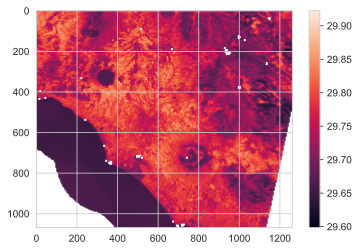

In [107]:
ar_test = np.array(df.estimated_air)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

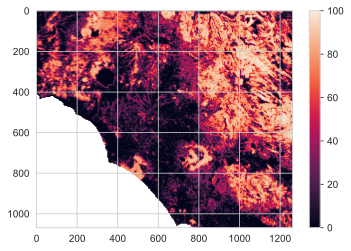

In [108]:
ar_test = np.array(tc)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

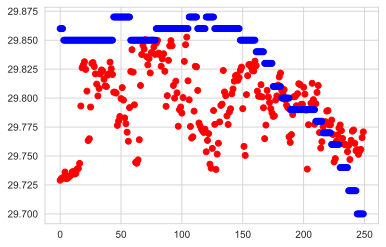

In [109]:
plt.plot(df['estimated_air'].head(250),marker='o',color='red',linestyle='None')
plt.plot(df['at'].head(250),marker='o',color='blue',linestyle='None')
plt.show()

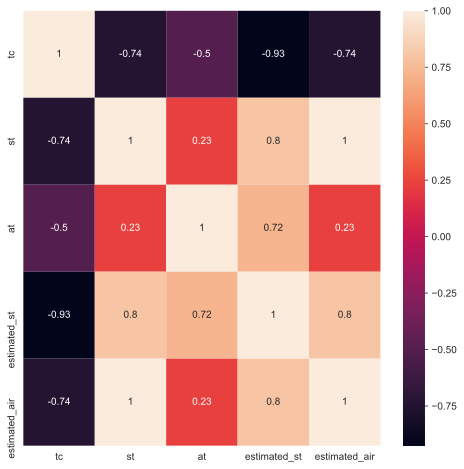

In [121]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
sns.heatmap(((df[['tc','st','at','estimated_st','estimated_air']]).corr()), annot=True)

#correlations:
#estimated_St and tc: -1
#estimated air and st. 1

In [37]:
df.head()

,st,at,lc,tc,eaaAr,bldgSum,elevation,tc0,estimated_st,err_st,estimated_st_tc0,estimated_air,err_at,estimated_at_tc0,cooling,propagated_error
0,37.26,29.86,311.0,63.0,NaN,0.0,175.0,0,37.494680,6.305672,43.295053,29.729076,0.474121,39.308903,9.579827,0.238903
1,37.41,29.86,311.0,74.0,NaN,0.0,180.0,0,36.481916,6.305673,43.295053,29.730593,0.474121,39.308903,9.578310,0.245476
2,37.41,29.86,311.0,74.0,NaN,0.0,181.0,0,36.481916,6.305673,43.295053,29.730593,0.474121,39.308903,9.578310,0.245476
3,37.54,29.85,311.0,74.0,NaN,0.0,180.0,0,36.481916,6.305673,43.295053,29.731907,0.474121,39.308903,9.576995,0.245476
4,37.96,29.85,311.0,69.0,NaN,0.0,180.0,0,36.942263,6.305673,43.295053,29.736154,0.474121,39.308903,9.572749,0.242443


In [131]:
df['coolingst'] = df['estimated_st_tc0']-df['estimated_st']
df['estimated_air'].mean()

29.73977942305571

In [38]:
df['deviation_est_st']=df['estimated_st'].mean()-df['estimated_st']
df['deviation_est_at']=df['estimated_air'].mean()-df['estimated_air']
uncertainty_est_st=abs(df['deviation_est_st']).mean()
uncertainty_est_at=abs(df['deviation_est_at']).mean()
df['prova']=df['deviation_est_st']**2
aa=df['prova'].mean()
aa
#uncertainty in the difference of two estimates: dq = dx + dy
uncertainty_cooling= uncertainty_est_at + uncertainty_est_st
uncertainty_cooling

3.3996347800491007

In [39]:
df.head()

,st,at,lc,tc,eaaAr,bldgSum,elevation,tc0,estimated_st,err_st,estimated_st_tc0,estimated_air,err_at,estimated_at_tc0,cooling,propagated_error,deviation_est_st,deviation_est_at,prova
0,37.26,29.86,311.0,63.0,NaN,0.0,175.0,0,37.494680,6.305672,43.295053,29.729076,0.474121,39.308903,9.579827,0.238903,2.380735,0.010703,5.667899
1,37.41,29.86,311.0,74.0,NaN,0.0,180.0,0,36.481916,6.305673,43.295053,29.730593,0.474121,39.308903,9.578310,0.245476,3.393499,0.009186,11.515833
2,37.41,29.86,311.0,74.0,NaN,0.0,181.0,0,36.481916,6.305673,43.295053,29.730593,0.474121,39.308903,9.578310,0.245476,3.393499,0.009186,11.515833
3,37.54,29.85,311.0,74.0,NaN,0.0,180.0,0,36.481916,6.305673,43.295053,29.731907,0.474121,39.308903,9.576995,0.245476,3.393499,0.007872,11.515833
4,37.96,29.85,311.0,69.0,NaN,0.0,180.0,0,36.942263,6.305673,43.295053,29.736154,0.474121,39.308903,9.572749,0.242443,2.933151,0.003625,8.603378


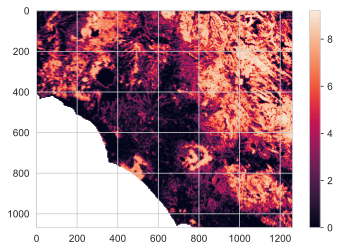

In [117]:
ar_test = np.array(df.coolingst)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

In [69]:
#cooling = np.array(df.cooling)
#cooling=cooling.reshape(kwds['height'],kwds['width'])
#cooling.shape

(1069, 1262)

In [184]:
#failing to write raster

with rasterio.open(eaa_raster_address) as src:
        eaaAr=src.read(1, window=window_use)
        eaaNoData = (src.meta.copy())['nodata']
        arrayShapes=eaaAr.shape
        profile=src.profile
        #eaaAr=eaaAr.flatten()
        
cooling = np.array(df.cooling)
cooling=cooling.reshape(kwds['height'],kwds['width'])

outputFolder=r''

coolingtowriteraster     = outputFolder +r'\cooling.img'

ardatatype='float64'

cooling= (cooling).astype(ardatatype)
profile['dtype']=ardatatype

with rasterio.open(coolingtowriteraster, 'w', **profile) as output:
    output.write_band(1,cooling)

CPLE_OpenFailedError: Creation of file \cooling.img failed.

In [181]:

eaaAr.shape

(1069, 1262)

In [51]:
cooling = np.array(df.cooling)
cooling=cooling.reshape(kwds['height'],kwds['width'])

In [56]:
ardatatype='float64'

coolingtowriterast = rasterio.open(
...     'C:\EU_JRC_Urban_Heat_Mitigation-master\cooling.tif',
...     'w',
...     driver='GTiff',
...     height=eaaAr.shape[0],
...     width=eaaAr.shape[1],
...     count=1,
...     dtype=eaaAr.astype(ardatatype),
...     crs={'init':'epsg: 3035'},
...     transform=src.transform,
... )
coolingtowriterast.write(cooling, 1)
coolingtowriterast.close()

SyntaxError: invalid syntax (<ipython-input-56-6fce4a7cb177>, line 4)

In [44]:
with rasterio.open(eaa_raster_address) as src:
        eaaAr=src.read(1, window=window_use)
        eaaNoData = (src.meta.copy())['nodata']
        arrayShapes=eaaAr.shape

In [21]:
src.transform

Affine(100.0, 0.0, 4472035.294429064,
       0.0, -100.0, 2148765.1616077223)

In [22]:
src.crs

CRS.from_wkt('PROJCS["ETRS89-extended / LAEA Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [43]:
eaaAr.shape

(1349078,)